In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
# Paths of folders containing train and test data
TRAIN_FOLDER_PATH = "features_train"
TEST_FOLDER_PATH = "features_test"

In [4]:
# Names of features based on GeMAPS feature set
meta_data = pd.read_csv('feature_description.csv', encoding='ISO-8859-1', header=None)
col_names = list(meta_data[0])

In [5]:
df_dict = {'Participant_ID': [], 'features': []}  # Dict to store values
max_rows = 0  # Max number of rows present in the data (used for padding)

for file in os.listdir(TRAIN_FOLDER_PATH):
    
    file_name_split = file.split('.')
    file_type = file_name_split[1]
    file_name = file_name_split[0]

    if file_type == 'csv':
        # Fetch participant ID
        id = int(file_name.split('_')[1])
        df_dict['Participant_ID'].append(id)

        # Fetch data
        temp_df = pd.read_csv(TRAIN_FOLDER_PATH + '/' + file, names=col_names)

        # Remove null values
        if temp_df.isna().sum().values[0]>0:
            print(f"Removing null values present in {file}")
            temp_df = temp_df.dropna(axis=0)
        
        # Filter out rows where more than half of the feature values are zero
        zero_percentages = (temp_df == 0).mean(axis=1)  # Calculate the percentage of zero values in each row
        threshold = 0.5  # More than half
        temp_df = temp_df[zero_percentages <= threshold]
        
        # Add the features to dict
        df_dict['features'].append(temp_df)
        
        # Update max rows
        if temp_df.shape[0]>max_rows:
            max_rows = temp_df.shape[0] 

Removing null values present in spk_402.csv


In [6]:
max_rows

378

In [7]:
# Pad zeroes
for i in range(len(df_dict['features'])):
    df_dict['features'][i] = df_dict['features'][i].reindex(np.arange(max_rows), fill_value=0).values

In [8]:
# Convert the dict into dataframe
df_features = pd.DataFrame(df_dict)

In [9]:
# Read labels dict
df_labels = pd.read_csv('labels.csv', skipfooter=1, engine='python')
df_labels['Participant_ID'] = df_labels['Participant_ID'].astype(int)
df_labels.head()

,Participant_ID,Depression,Gender
0,303,0,0
1,304,0,0
2,305,0,1
3,310,0,1
4,312,0,1


In [10]:
merged_df = pd.merge(df_features, df_labels, on='Participant_ID')

In [11]:
merged_df.head()

,Participant_ID,features,Depression,Gender
0,448,"[[33.88331, 0.18847024, 31.197649, 31.198807, ...",1,1
1,475,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
2,313,"[[22.360157, 0.071260795, 20.776451, 22.337982...",0,1
3,449,"[[31.251434, 0.008560931, 31.196766, 31.198511...",0,0
4,339,"[[19.374094, 0.07061678, 18.158512, 18.906977,...",1,1


In [12]:
# Extract Features and Labels for tensorflow
features = merged_df['features'].to_list()
depression_labels = merged_df['Depression'].values
gender_labels = merged_df['Gender'].values

In [13]:
# Convert features to tensor object
features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
features = np.array(features_tensor).reshape(87, 378, 88, 1)

# Convert labels to proper shape
depression_labels = np.asarray(depression_labels).astype('float32').reshape((-1,1))
gender_labels = np.asarray(gender_labels).astype('float32').reshape((-1,1))

In [14]:
features.shape

(87, 378, 88, 1)

In [15]:
# define and train CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same",strides = (1,1), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                           input_shape=(378, 88, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (2, 2),  padding = "same",strides = (1,1),activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(4, (2, 2), activation='relu', padding = "same",strides = (1,1),
    #                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
   
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(features_tensor, depression_labels, epochs=50, batch_size=32, validation_split=0.15)

Epoch 1/50
3/3 [==============================] - 1s 97ms/step - loss: 251.2788 - accuracy: 0.4658 - val_loss: 48.6884 - val_accuracy: 0.8571
Epoch 2/50
3/3 [==============================] - 0s 65ms/step - loss: 96.9179 - accuracy: 0.6986 - val_loss: 0.9363 - val_accuracy: 0.2857
Epoch 3/50
3/3 [==============================] - 0s 64ms/step - loss: 0.7405 - accuracy: 0.4658 - val_loss: 0.7338 - val_accuracy: 0.8571
Epoch 4/50
3/3 [==============================] - 0s 65ms/step - loss: 0.7343 - accuracy: 0.5890 - val_loss: 0.5760 - val_accuracy: 0.8571
Epoch 5/50
3/3 [==============================] - 0s 63ms/step - loss: 1.3181 - accuracy: 0.5890 - val_loss: 0.5356 - val_accuracy: 0.8571
Epoch 6/50
3/3 [==============================] - 0s 64ms/step - loss: 0.8127 - accuracy: 0.6986 - val_loss: 0.5694 - val_accuracy: 0.8571
Epoch 7/50
3/3 [==============================] - 0s 62ms/step - loss: 0.7286 - accuracy: 0.7123 - val_loss: 0.6424 - val_accuracy: 0.7857
Epoch 8/50
3/3 [=======

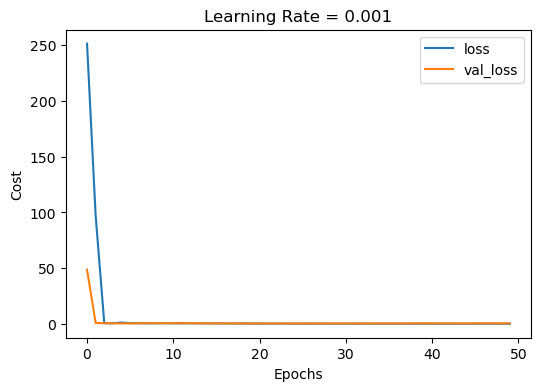

In [16]:
# plot the model
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [17]:
# define and train CNN Model
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), padding = "same",strides = (1,1), activation='relu',
                           input_shape=(378, 88, 1)),
    
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(16, (2, 2),  padding = "same",strides = (1,1),activation='relu'),
  
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    
    # tf.keras.layers.Conv2D(4, (2, 2), activation='relu', padding = "same",strides = (1,1),
    #                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(features_tensor, depression_labels, epochs=50, batch_size=32, validation_split=0.15)

Epoch 1/50
3/3 [==============================] - 0s 71ms/step - loss: 349.3267 - accuracy: 0.4521 - val_loss: 39.8434 - val_accuracy: 0.8571
Epoch 2/50
3/3 [==============================] - 0s 48ms/step - loss: 88.7182 - accuracy: 0.6986 - val_loss: 1.6534 - val_accuracy: 0.8571
Epoch 3/50
3/3 [==============================] - 0s 48ms/step - loss: 1.8797 - accuracy: 0.6164 - val_loss: 0.6935 - val_accuracy: 0.1429
Epoch 4/50
3/3 [==============================] - 0s 51ms/step - loss: 0.6933 - accuracy: 0.3014 - val_loss: 0.6935 - val_accuracy: 0.1429
Epoch 5/50
3/3 [==============================] - 0s 47ms/step - loss: 0.6933 - accuracy: 0.3014 - val_loss: 0.6933 - val_accuracy: 0.1429
Epoch 6/50
3/3 [==============================] - 0s 47ms/step - loss: 0.6932 - accuracy: 0.3425 - val_loss: 0.6929 - val_accuracy: 0.8571
Epoch 7/50
3/3 [==============================] - 0s 48ms/step - loss: 0.6930 - accuracy: 0.6986 - val_loss: 0.6924 - val_accuracy: 0.8571
Epoch 8/50
3/3 [=======

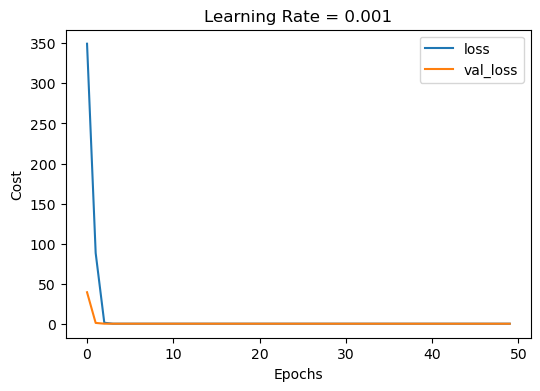

In [18]:
# plot the model
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history2.history["loss"], label="loss")
plt.plot(history2.history["val_loss"], label="val_loss")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()

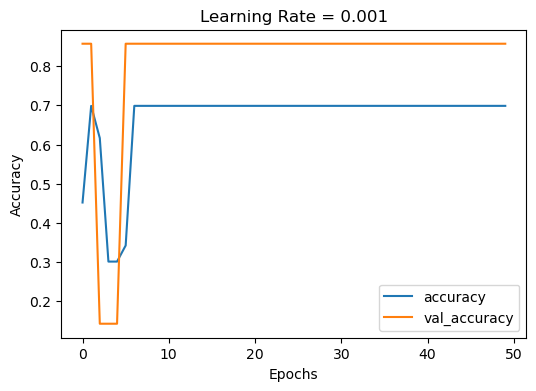

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history2.history["accuracy"], label="accuracy")
plt.plot(history2.history["val_accuracy"], label="val_accuracy")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Test Data

In [20]:
test_df_dict = {'Participant_ID': [], 'features': []}  # Dict to store values
max_rows = max_rows  # Max number of rows present in the training data (used for padding)

for file in os.listdir(TEST_FOLDER_PATH):
    
    file_name_split = file.split('.')
    file_type = file_name_split[1]
    file_name = file_name_split[0]

    if file_type == 'csv':
        # Fetch participant ID
        id = int(file_name.split('_')[1])
        test_df_dict['Participant_ID'].append(id)

        # Fetch data
        temp_df = pd.read_csv(TEST_FOLDER_PATH + '/' + file, names=col_names)

        # Remove null values
        if temp_df.isna().sum().values[0]>0:
            print(f"Removing null values present in {file}")
            temp_df = temp_df.dropna(axis=0)
        
        # Filter out rows where more than half of the feature values are zero
        zero_percentages = (temp_df == 0).mean(axis=1)  # Calculate the percentage of zero values in each row
        threshold = 0.5  # More than half
        temp_df = temp_df[zero_percentages <= threshold]
        
        # Add the features to dict
        test_df_dict['features'].append(temp_df)

In [21]:
# Pad zeroes
for i in range(len(test_df_dict['features'])):
    test_df_dict['features'][i] = test_df_dict['features'][i].reindex(np.arange(max_rows), fill_value=0).values

In [22]:
# Convert the dict into dataframe
test_features = pd.DataFrame(test_df_dict)

In [23]:
test_merged_df = pd.merge(test_features, df_labels, on='Participant_ID')
test_merged_df.head()

,Participant_ID,features,Depression,Gender
0,474,"[[31.240383, 0.007704522, 31.195211, 31.19749,...",0,1
1,312,"[[59.940285, 0.025738925, 58.02941, 60.76215, ...",0,1
2,305,"[[32.160255, 0.20058103, 23.145561, 35.63253, ...",0,1
3,315,"[[13.185594, 0.018975748, 12.951183, 13.3119, ...",0,1
4,415,"[[34.831165, 0.25052992, 31.193499, 31.198702,...",0,0


In [24]:
# Extract Features and Labels for tensorflow
test_features = test_merged_df['features'].to_list()
test_depression_labels = test_merged_df['Depression'].values
test_gender_labels = test_merged_df['Gender'].values

In [27]:
# Convert features to tensor object
test_features_tensor = tf.convert_to_tensor(test_features, dtype=tf.float32)
test_features = np.array(test_features_tensor).reshape(20, 378, 88, 1)

# Convert labels to proper shape
test_depression_labels = np.asarray(test_depression_labels).astype('float32').reshape((-1,1))
test_gender_labels = np.asarray(test_gender_labels).astype('float32').reshape((-1,1))

In [28]:
test_features.shape

(20, 378, 88, 1)

In [30]:
test_loss, test_acc = model.evaluate(test_features,  test_depression_labels)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

1/1 [==============================] - 0s 26ms/step - loss: 1.4746 - accuracy: 0.7000
Test loss:  1.4745861291885376
Test accuracy:  0.699999988079071


In [31]:
test_loss_2, test_acc_2 = model2.evaluate(test_features,  test_depression_labels)
print("Test loss: ", test_loss_2)
print("Test accuracy: ", test_acc_2)

1/1 [==============================] - 0s 76ms/step - loss: 0.6739 - accuracy: 0.7000
Test loss:  0.6738673448562622
Test accuracy:  0.699999988079071


1/1 [==============================] - 0s 23ms/step
Confusion Matrix 
 [[14  0]
 [ 6  0]]


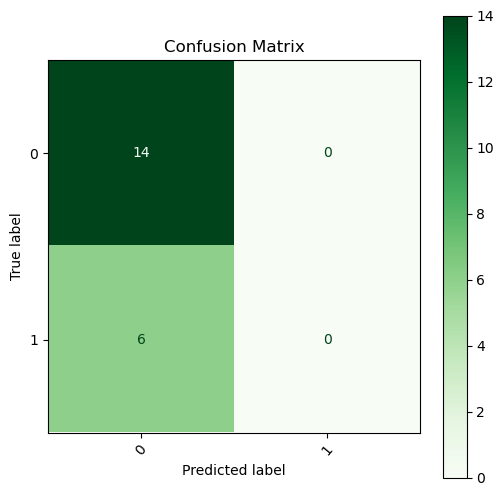

In [38]:
#Making predictions for the test set with the CNN model from b)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = model2.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_depression_labels, y_pred_classes)
print("Confusion Matrix \n", conf_matrix)

#Visualizing the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='Greens', xticks_rotation=50)
plt.title('Confusion Matrix')
plt.show()